<a href="https://colab.research.google.com/github/lmarieta/FaceRecognition/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, upload data.RData, data_submission.RData, IdLookupTable.csv files. After training your model, you can download it. After saving the output file, you can also download it.

Import Libraries


In [174]:
import numpy as np
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
#from sklearn import train_test_split
import matplotlib.pyplot as plt
!pip install pyreadr
import pyreadr
from keras.optimizers import Adam
from timeit import default_timer
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

Initialization

In [175]:
epochs = 400

Load data

In [176]:
filename = '/content/data.RData'
df = pyreadr.read_r(filename)

x_train = df['im.train']
y_train = df['d.train']
x_test = df['im.test']
y_test = df['d.test']

# Get the indices of rows containing NaN values. Note that train and test splits are random with a given seed.
nan_indices_train = x_train.index[x_train.isnull().any(axis=1)].tolist() + y_train.index[y_train.isnull().any(axis=1)].tolist()
nan_indices_test = x_test.index[x_test.isnull().any(axis=1)].tolist() + y_test.index[y_test.isnull().any(axis=1)].tolist()

# Drop rows containing NaN values
x_train = x_train.drop(x_train.index[nan_indices_train])
y_train = y_train.drop(y_train.index[nan_indices_train])
x_test = x_test.drop(x_test.index[nan_indices_test])
y_test = y_test.drop(y_test.index[nan_indices_test])



Model selection

In [177]:
model_type = 'Convolutions' # options: {'Single hidden layer','Convolutions'}
df = pd.DataFrame({model_type}, columns=['Model type'])

# Start recording time
start = default_timer()

Single layer model

In [178]:
if model_type == 'Single hidden layer' :
  pixel_num = x_train.shape[1]
  keras.backend.clear_session()
  # Define the model (single hidden layer)
  model = keras.Sequential([
      keras.layers.Dense(64, activation='relu', input_shape=(pixel_num,)),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(y_train.shape[1])  # Output layer with 2 units per keypoint (x and y coordinates)
  ])
  learning_rate=0.05
  epsilon = 0.1
  optimizer = Adam(learning_rate=learning_rate,epsilon=epsilon)
  early_stopping = EarlyStopping(monitor='loss',patience=20, restore_best_weights=True)
  hyperparameters = {
    'optimizer': optimizer,
    'loss': 'mse',
    'learning_rate':learning_rate,
    'epsilon': epsilon,
    'early_stopping': early_stopping,
  }
  for k,v in hyperparameters.items():
    df[k] = v
  # Compile the model
  model.compile(optimizer=hyperparameters['optimizer'], loss=hyperparameters['loss'])

Dynamic momentum and learning rate

In [179]:
class MomentumScheduler(Callback):
    def __init__(self, schedule, decay_rate):
        super(MomentumScheduler, self).__init__()
        self.initial_schedule = schedule
        self.decay_rate = decay_rate

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'beta_1'):
            raise ValueError("Optimizer must have a 'beta_1' attribute.")
        momentum = self.initial_schedule + (self.decay_rate*epoch) / epochs
        self.model.optimizer.beta_1 = momentum


class LinearDecayLR(Callback):
    def __init__(self, initial_lr, decay_rate):
        super(LinearDecayLR, self).__init__()
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate

    def on_epoch_begin(self, epoch, logs=None):
        new_lr = self.initial_lr - (self.decay_rate * epoch) / epochs
        self.model.optimizer.lr = new_lr

# Initialize for learning rate and momentum
initial_momentum = 0.9
momentum_decay_rate = 0.999 - initial_momentum

initial_lr = 0.03
lr_decay_rate = 299 / 300 * initial_lr

# Create callbacks
momentum_callback = MomentumScheduler(initial_momentum, momentum_decay_rate)
lr_callback = LinearDecayLR(initial_lr, lr_decay_rate)


Convolutions model

In [180]:
#############################
#############################
# Data augmentation
# TODO Create a function f to prepare inputs for neural nets f(model_type,x) > x_new
#############################
#############################
if model_type == 'Convolutions' :
  # Convolutional neural net with three convolutional layers and two fully connected layers
  keras.backend.clear_session()
  pixel_num = np.sqrt(x_train.shape[1]).astype(int)
  # Assuming you have defined the input shape of your images
  input_shape = (pixel_num, pixel_num, 1)

  # Create the CNN model
  model = keras.Sequential()

  # Convolutional Layer 1
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))

  # Convolutional Layer 2
  model.add(Conv2D(64, (2, 2), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Convolutional Layer 3
  model.add(Conv2D(128, (2, 2), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Flatten the feature maps
  model.add(Flatten())

  # Fully Connected Layer 1
  model.add(Dense(500, activation='relu'))

  # Fully Connected Layer 2
  model.add(Dense(500, activation='relu'))

  # Output Layer
  model.add(Dense(y_train.shape[1]))

  # Create the Adam optimizer with the desired initial values
  optimizer = Adam(learning_rate=initial_lr, beta_1 = initial_momentum)

  # Compile the model
  model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

  # Print the model summary
  model.summary()
  # stop early
  early_stopping = EarlyStopping(monitor='loss',patience=30, restore_best_weights=True)
  # reshape inputs
  x_train = x_train.to_numpy().reshape(-1, pixel_num, pixel_num, 1)/255
  x_test = x_test.to_numpy().reshape(-1, pixel_num, pixel_num, 1)/255

  # Data augmentation
  # Create an instance of ImageDataGenerator with desired augmentation settings
  # data_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip = True)

  # Create a generator for training data
  batch_size = 32
  # train_generator = data_generator.flow(x_train, y_train, batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 128)      0

Analysis

In [181]:
# Train the model
history = model.fit(
    x_train, # train_generator instead of x, y
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[lr_callback, momentum_callback],
    validation_data=(x_test, y_test)
    )

# Extract the loss and validation loss values from the history object
loss_values = history.history['loss']
val_loss = history.history['val_loss']

# Convert loss_values to a DataFrame
df_loss = pd.DataFrame({'Epoch': np.arange(1, len(loss_values) + 1), 'Loss': val_loss})

# Make predictions
predictions = model.predict(x_test)

# Size of the image is given, prediction cannot be outside of range
min_value = 0
max_value = 96
constrained_predictions = np.clip(predictions, min_value, max_value)

# Save the model to a file
model.save('/content/model.h5')

# Duration
duration = default_timer() - start
print(duration)
df['Duration'] = duration

Epoch 1/400
 5/55 [=>............................] - ETA: 0s - loss: 3550.2837 - accuracy: 0.0000e+00 

55/55 [==============================] - 1s 17ms/step - loss: 517.7125 - accuracy: 0.5806 - val_loss: 10.2913 - val_accuracy: 0.7065
Epoch 2/400
55/55 [==============================] - 1s 12ms/step - loss: 10.9812 - accuracy: 0.7048 - val_loss: 10.4498 - val_accuracy: 0.7065
Epoch 3/400
55/55 [==============================] - 1s 12ms/step - loss: 10.9991 - accuracy: 0.7048 - val_loss: 10.2418 - val_accuracy: 0.7065
Epoch 4/400
55/55 [==============================] - 1s 12ms/step - loss: 11.0653 - accuracy: 0.7048 - val_loss: 11.9778 - val_accuracy: 0.7065
Epoch 5/400
55/55 [==============================] - 1s 11ms/step - loss: 12.4256 - accuracy: 0.7048 - val_loss: 12.0937 - val_accuracy: 0.7065
Epoch 6/400
55/55 [==============================] - 1s 12ms/step - loss: 11.4352 - accuracy: 0.7048 - val_loss: 17.6534 - val_accuracy: 0.7065
Epoch 7/400
55/55 [==============================] - 1s 11ms/step - loss: 11.8604 - accuracy: 0.7048 - val_loss: 14.6844 - val_accuracy: 0.7065
Epo

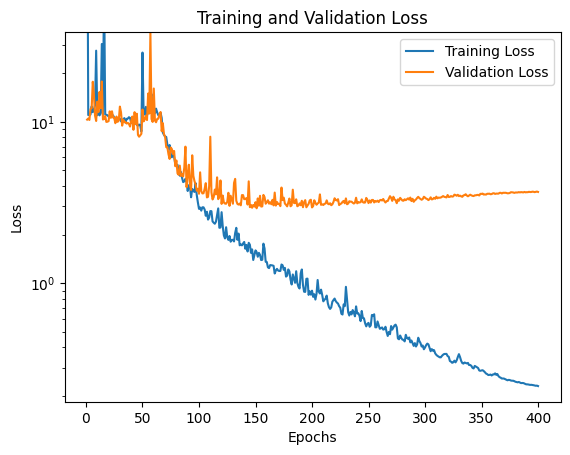

In [182]:
# Plot the training and validation loss
plt.figure()
plt.plot(df_loss['Epoch'], loss_values, label='Training Loss')
plt.plot(df_loss['Epoch'], val_loss, label='Validation Loss')
plt.yscale('log')
plt.ylim(0.8*np.min(loss_values),np.max(val_loss))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [183]:
# First, calculate the column means along axis 0 (columns)
col_means = np.nanmean(y_test, axis=0)

# Next, create the matrix 'p' using the calculated column means
num_rows_d_test = y_test.shape[0]
num_cols_d_train = y_train.shape[1]

# Create the matrix 'p' with the specified dimensions and fill it with column means
p = np.tile(col_means, (num_rows_d_test, 1)).astype(y_test.dtypes)

# Compute RMSE
rmse = np.sqrt(df_loss['Loss'].iloc[-1])

# Print RMSE
print('RMSE : ')
print(rmse)
df['RMSE'] = rmse
df.to_csv('/content/performance.csv',mode='a')

RMSE : 
1.916238287723827


In [184]:
df_predictions = pd.DataFrame(predictions)

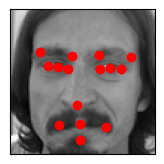

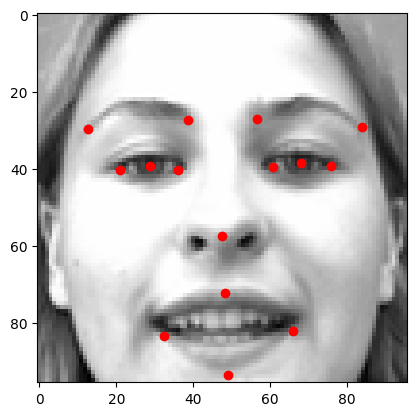

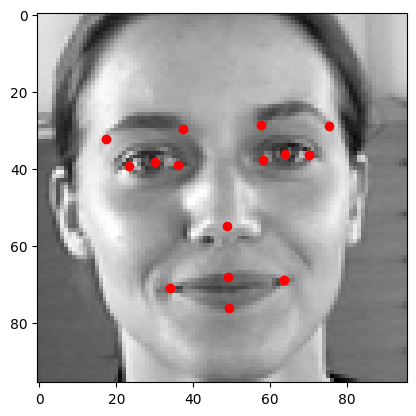

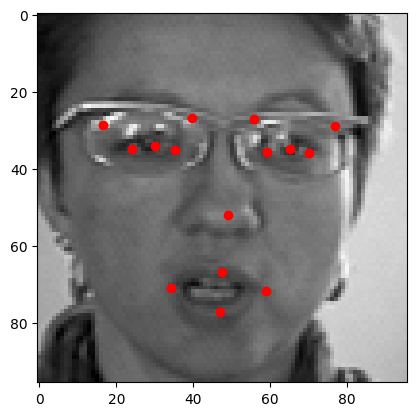

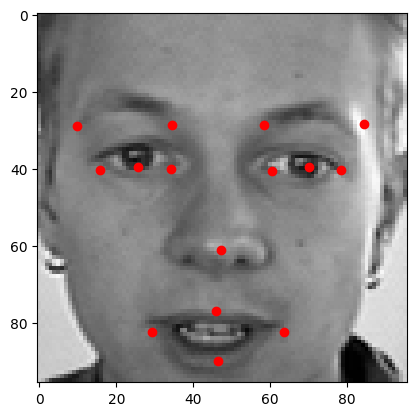

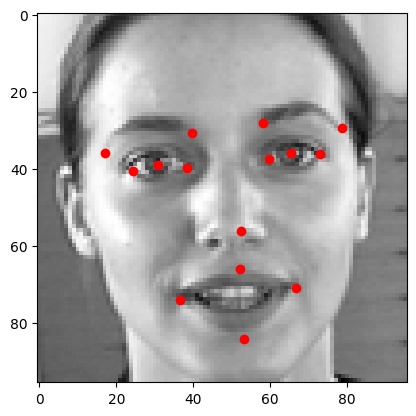

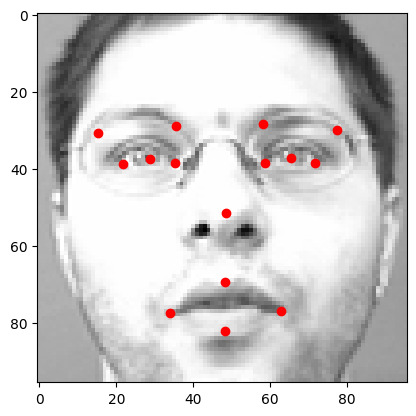

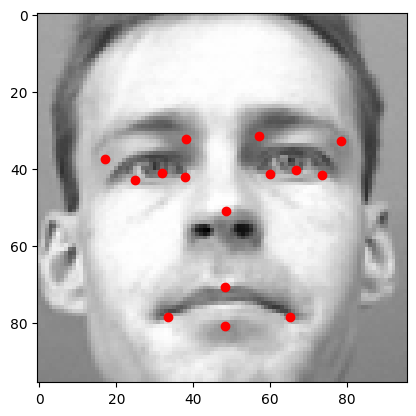

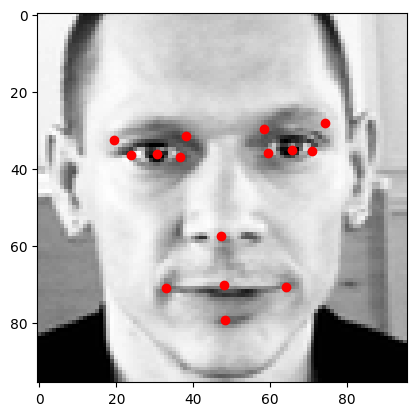

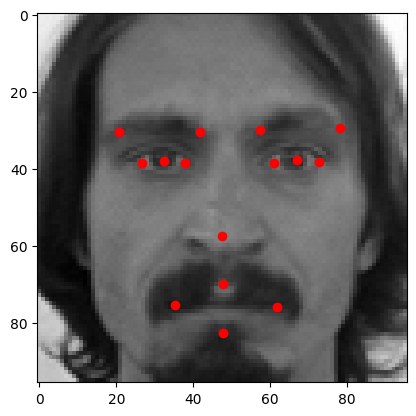

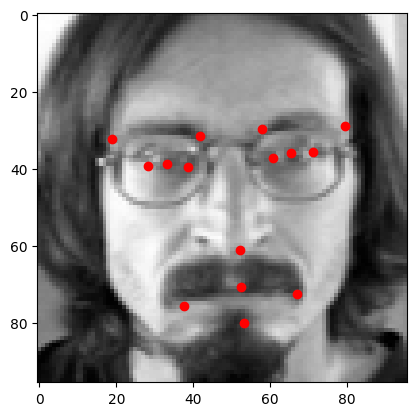

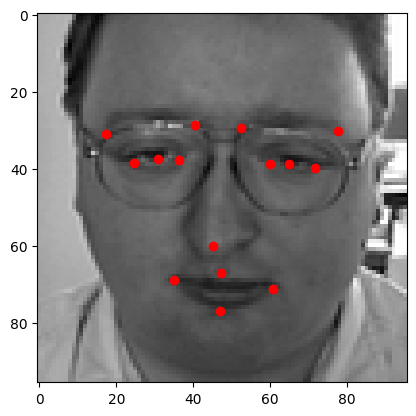

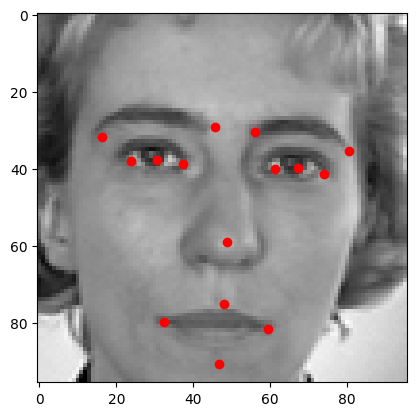

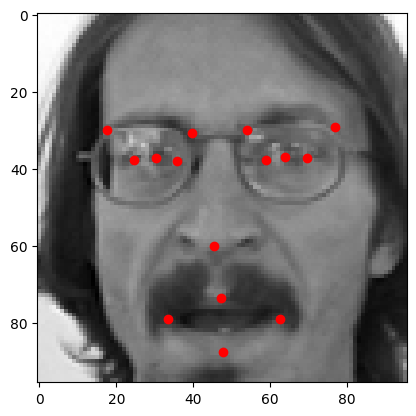

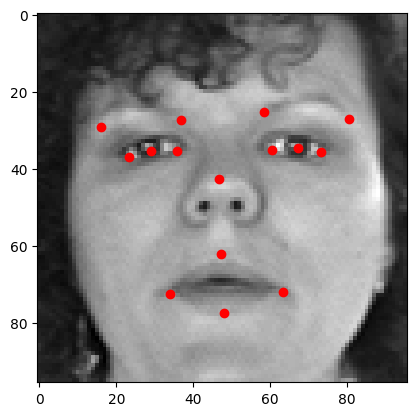

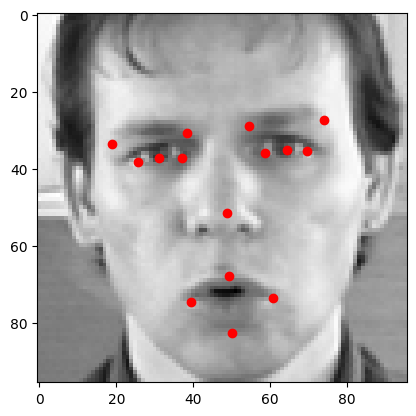

In [185]:
# Plot the first 16 images in the DataFrame

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
  if model_type == 'Single hidden layer':
    image = np.array(x_test.iloc[i,:])  # Convert the Series to a NumPy array
    image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
  elif model_type == 'Convolutions':
    image = x_test[i]
    image = image.reshape((96, 96))
  ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
  predicted_keypoints = predictions[i].reshape((15, 2))
  plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
  plt.imshow(image, cmap='gray')
  plt.show()

56/56 [==============================] - 0s 4ms/step


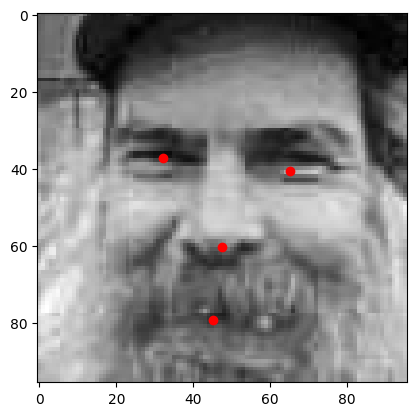

In [186]:
#TODO move below
# from pandas.io.parsers.readers import read_csv
# Extract data for output
filename = '/content/data_submission.RData'
df_submission = pyreadr.read_r(filename)
x_submission = df_submission['im_submission']
# Get the indices of rows containing NaN values.
nan_indices_submission = x_submission.index[x_submission.isnull().any(axis=1)].tolist()
# Drop rows containing NaN values
x_submission = x_submission.drop(x_submission.index[nan_indices_submission])
if model_type == 'Convolutions' :
  x_submission = x_submission.to_numpy().reshape(-1, pixel_num, pixel_num, 1)/255

# Make predictions
predictions_submission = model.predict(x_submission)

# Size of the image is given, prediction cannot be outside of range
min_value = 0
max_value = 96
constrained_predictions_submission = np.clip(predictions_submission, min_value, max_value)

# Remove predictions not requested in IdLookupTable.csv
filename = '/content/IdLookupTable.csv'
IdLookupTable = pd.read_csv(filename)
# All keypoints names
keypoints_names = IdLookupTable['FeatureName'].iloc[0:30]
# Calculate the repeating sequence based on the number of rows in 'df'
repeating_sequence = np.repeat(np.arange(1, 1783*30 // 30 + 1), 30)
# Add the repeating sequence as a new column to the DataFrame
keypoints_names_filter = pd.DataFrame({'ImageId': repeating_sequence})
keypoints_names_filter['Indices'] = range(len(keypoints_names_filter))
keypoints_names_filter['FeatureName'] = pd.concat([keypoints_names] * 1783, ignore_index=True)
# Filter
keypoints_names_filter = keypoints_names_filter.merge(IdLookupTable[['ImageId', 'FeatureName']], on=['ImageId', 'FeatureName'], how='inner')
# Create a mask of size 1783x30 where True indicates the indices to keep
nb_output_images = x_submission.shape[0]
mask = np.isin(np.arange(nb_output_images*30), keypoints_names_filter['Indices'])
# Reshape the mask to the same shape as 'np_array'
mask = mask.reshape(constrained_predictions_submission.shape)
# Use the mask to replace values in the NumPy array with NaN
constrained_predictions_submission[~mask] = np.nan

# Plot the first image in the DataFrame
ii = -1
if model_type == 'Single hidden layer':
  image = np.array(x_submission.iloc[ii,:])
  image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
elif model_type == 'Convolutions':
  image = x_submission[ii]
  image = image.reshape((96, 96))
predicted_keypoints = constrained_predictions_submission[ii].reshape((15, 2))
plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
plt.imshow(image, cmap='gray')
plt.show()

# Prepare for output file
df_predictions = pd.DataFrame(constrained_predictions_submission)

# Convert the DataFrame to a NumPy array and reshape it
reshaped_values = df_predictions.values.reshape(-1, 1)

# Remove NaN values from the NumPy array
reshaped_values = reshaped_values[~np.isnan(reshaped_values)]

# Create a new DataFrame with the reshaped values
reshaped_df = pd.DataFrame(reshaped_values, columns=['Value'])
indices = pd.DataFrame(range(1,len(reshaped_df)+1))
submission = pd.concat([indices, reshaped_df], axis=1)
submission.rename(columns={0: 'RowId','Value': 'Location'}, inplace=True)

# Write to csv file
submission.to_csv('/content/model_submission.csv',index=False)
